# **Uploading the dataset**

In [46]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
from warnings import filterwarnings
filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


In [47]:
# print(x_train)
x_train.shape


(60000, 28, 28)

**Flatten to a single tensor**

In [48]:
x_train_flat = x_train.reshape(len(x_train), 28*28)
x_test_flat = x_test.reshape(len(x_test), 28*28)


In [49]:
x_train_flat.shape

(60000, 784)

**Converting to pytorch tensor's**

In [50]:

x_train_tensor = torch.tensor(x_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


**Neural Network class**

In [51]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[128, 64, 32], output_size=10):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        current_size = input_size

        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(current_size, hidden_size))
            current_size = hidden_size

        self.output_layer = nn.Linear(current_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.softmax(self.output_layer(x))
        return x


**Train, Test and plotting the results**

In [52]:
def train_model(model, optimizer, criterion, x_train_tensor, y_train_tensor, threshold=1e-4, max_epochs=100):
    epochs = 0
    previous_loss = float('inf')
    train_losses = []

    while epochs < max_epochs:
        epochs += 1
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_losses.append(current_loss)

        if epochs % 10 == 0:
            print(f"Epoch {epochs}, Loss: {current_loss}")

        if abs(previous_loss - current_loss) < threshold:
            print(f"Training stopped at epoch {epochs} with loss {current_loss}")
            break

        previous_loss = current_loss

    return epochs, train_losses

def test_model(model, x_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(x_test_tensor)
        _, predicted = torch.max(outputs, 1)
        test_accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
        conf_matrix = confusion_matrix(y_test_tensor.cpu(), predicted.cpu())
        return test_accuracy, conf_matrix

def plot_training_loss(epochs_list, loss_list, optimizer_name):
    plt.plot(range(1, epochs_list+1), loss_list, label=f'{optimizer_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')
    plt.legend()
    plt.show()



Training with SGD
Epoch 10, Loss: 2.3412673473358154
Epoch 20, Loss: 2.3362069129943848
Epoch 30, Loss: 2.3291797637939453
Epoch 40, Loss: 2.319112777709961
Epoch 50, Loss: 2.3061716556549072
Epoch 60, Loss: 2.293539047241211
Epoch 70, Loss: 2.282560348510742
Epoch 80, Loss: 2.2726120948791504
Epoch 90, Loss: 2.2633414268493652
Epoch 100, Loss: 2.2546722888946533


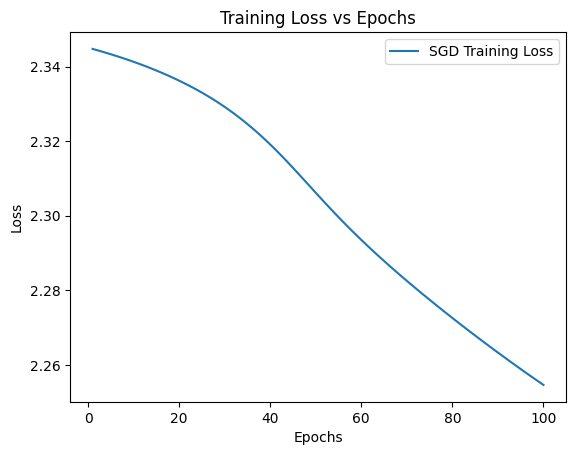

SGD Test Accuracy: 0.2038


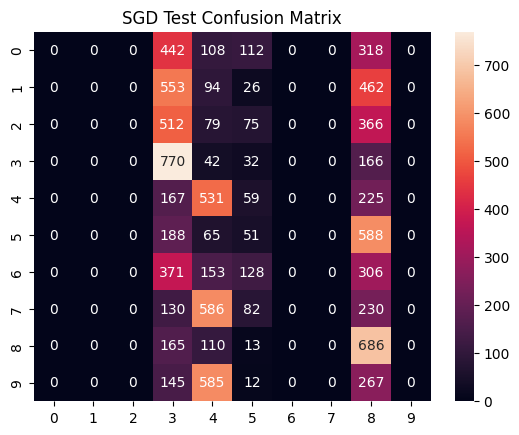


Training with SGD with momentum
Epoch 10, Loss: 2.236118793487549
Epoch 20, Loss: 2.050766706466675
Epoch 30, Loss: 1.9795424938201904
Epoch 40, Loss: 1.9496084451675415
Epoch 50, Loss: 1.9322586059570312
Epoch 60, Loss: 1.920003890991211
Epoch 70, Loss: 1.910412311553955
Epoch 80, Loss: 1.902965784072876
Epoch 90, Loss: 1.8965046405792236
Epoch 100, Loss: 1.884671688079834


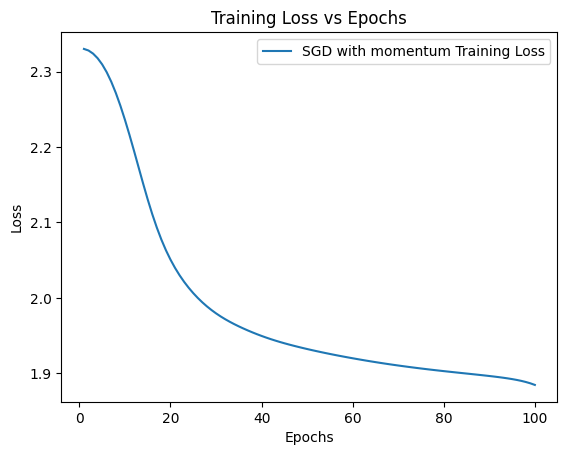

SGD with momentum Test Accuracy: 0.5836


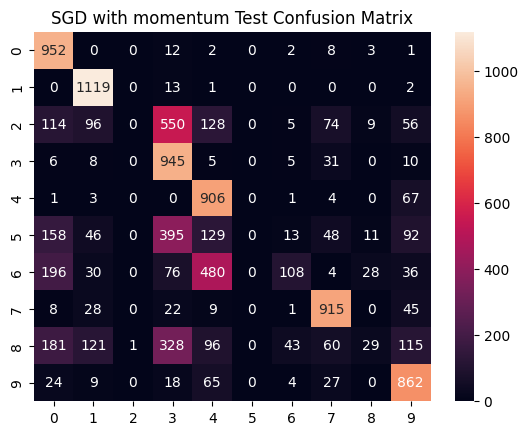


Training with SGD with NAG
Epoch 10, Loss: 2.2422916889190674
Epoch 20, Loss: 2.117471694946289
Epoch 30, Loss: 2.036893844604492
Epoch 40, Loss: 1.9634435176849365
Epoch 50, Loss: 1.9008744955062866
Epoch 60, Loss: 1.8402347564697266
Epoch 70, Loss: 1.8071502447128296
Epoch 80, Loss: 1.7890859842300415
Epoch 90, Loss: 1.7748963832855225
Epoch 100, Loss: 1.7519899606704712


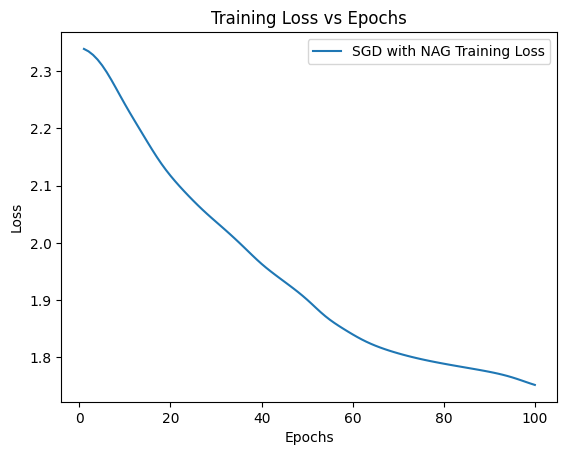

SGD with NAG Test Accuracy: 0.7386


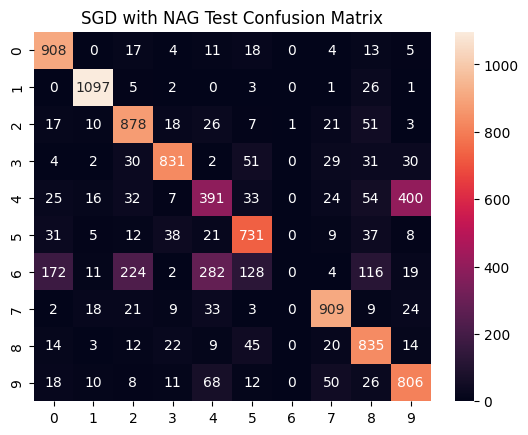


Training with RMSProp
Training stopped at epoch 4 with loss 2.3625168800354004


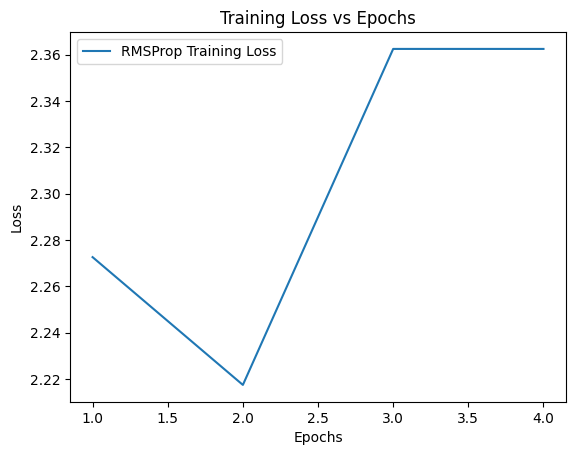

RMSProp Test Accuracy: 0.0958


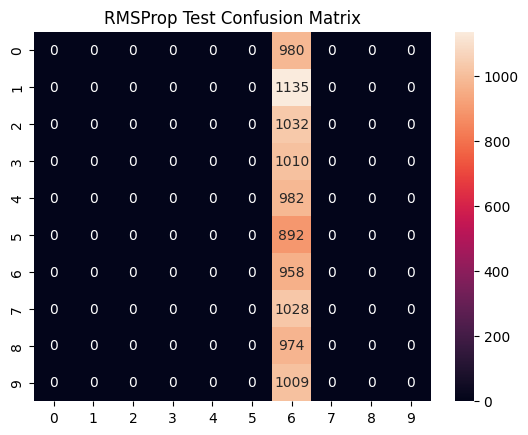


Training with Adam
Epoch 10, Loss: 1.7737653255462646
Epoch 20, Loss: 1.6420010328292847
Epoch 30, Loss: 1.6170192956924438
Epoch 40, Loss: 1.6043821573257446
Epoch 50, Loss: 1.5969595909118652
Epoch 60, Loss: 1.5914751291275024
Epoch 70, Loss: 1.5873026847839355
Epoch 80, Loss: 1.5841435194015503
Epoch 90, Loss: 1.5816773176193237
Epoch 100, Loss: 1.5796078443527222


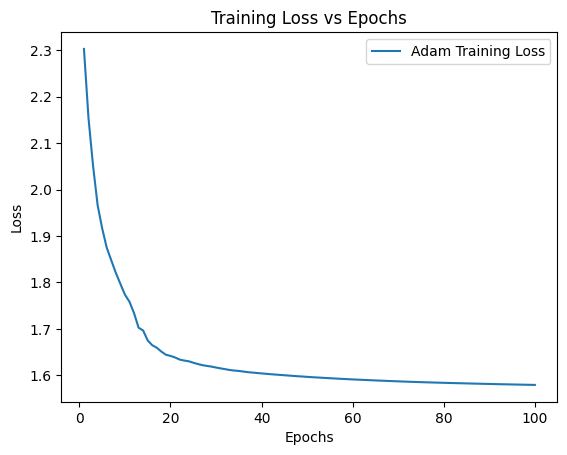

Adam Test Accuracy: 0.8689


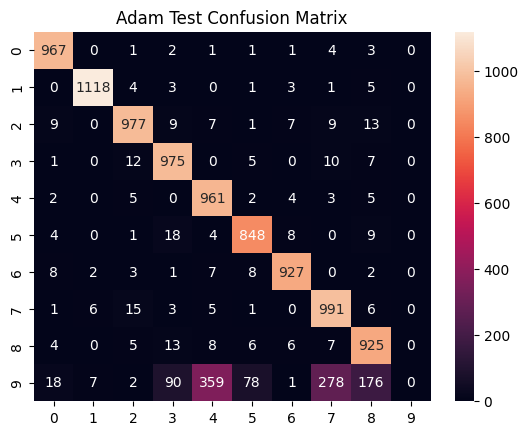

In [53]:
hidden_layers = [128, 64, 32]

# Training with different optimizers
optimizers = {
    'SGD': optim.SGD,
    'SGD with momentum': lambda params: optim.SGD(params, lr=0.001, momentum=0.9),
    'SGD with NAG': lambda params: optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True),
    'RMSProp': lambda params: optim.RMSprop(params, lr=0.001, alpha=0.99),
    'Adam': lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
}

optimizer_losses_dict = {}

for optimizer_name, optimizer_func in optimizers.items():
    print(f"\nTraining with {optimizer_name}")
    model = NeuralNetwork(hidden_sizes=hidden_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_func(model.parameters())

    epochs, train_losses = train_model(model, optimizer, criterion, x_train_tensor, y_train_tensor)
    plot_training_loss(epochs, train_losses, optimizer_name)

    # Storing the losses for plotting
    optimizer_losses_dict[optimizer_name] = train_losses

    test_accuracy, conf_matrix = test_model(model, x_test_tensor, y_test_tensor)
    print(f"{optimizer_name} Test Accuracy: {test_accuracy:.4f}")

    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title(f'{optimizer_name} Test Confusion Matrix')
    plt.show()


**Visualising Training loss for each optimiser**

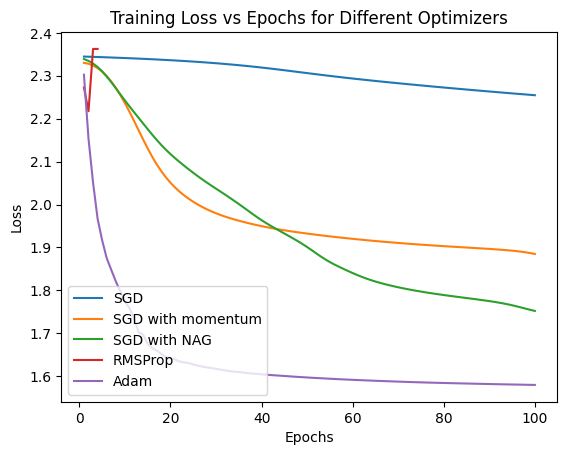

In [54]:
def plot_superimposed_losses(optimizer_losses_dict):
    for optimizer_name, losses in optimizer_losses_dict.items():
        plt.plot(range(1, len(losses)+1), losses, label=f'{optimizer_name}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs for Different Optimizers')
    plt.legend()
    plt.show()

plot_superimposed_losses(optimizer_losses_dict)



Training with SGD
Training stopped at epoch 2 with loss 2.309225082397461


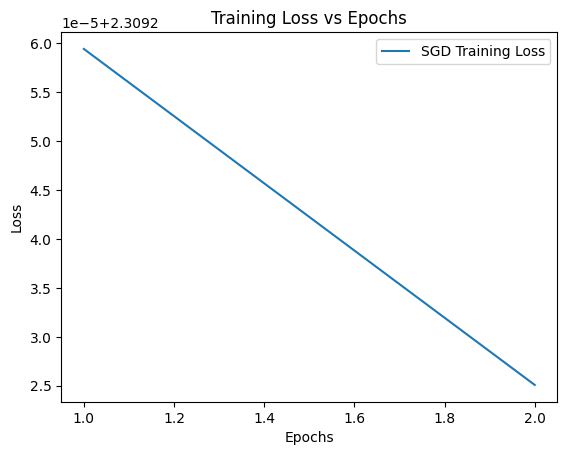

SGD Test Accuracy: 0.0965


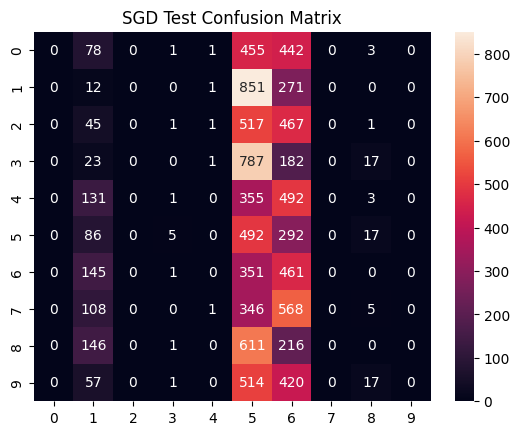


Training with SGD with momentum
Epoch 10, Loss: 2.305708885192871
Epoch 20, Loss: 2.2971744537353516
Epoch 30, Loss: 2.2886781692504883
Epoch 40, Loss: 2.2789478302001953
Epoch 50, Loss: 2.266003370285034
Epoch 60, Loss: 2.249150276184082
Epoch 70, Loss: 2.227208375930786
Epoch 80, Loss: 2.2004148960113525
Epoch 90, Loss: 2.170844078063965
Epoch 100, Loss: 2.14165997505188


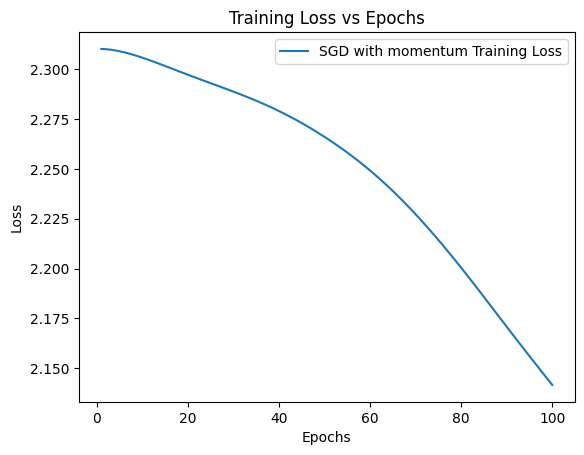

SGD with momentum Test Accuracy: 0.3355


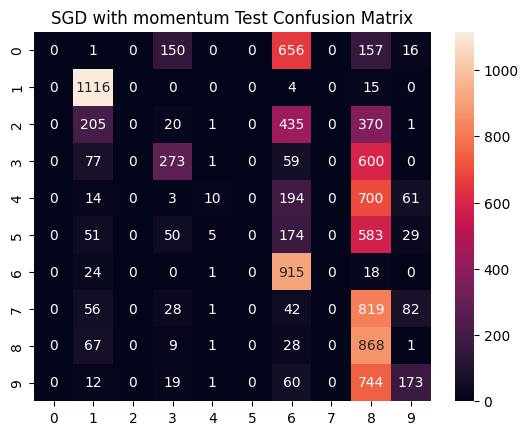


Training with SGD with NAG
Training stopped at epoch 2 with loss 2.3043930530548096


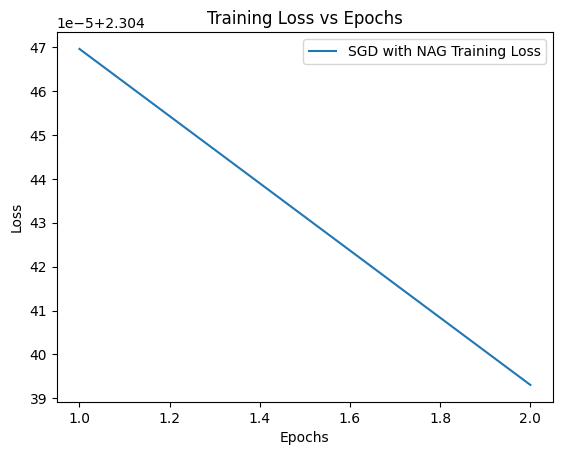

SGD with NAG Test Accuracy: 0.1175


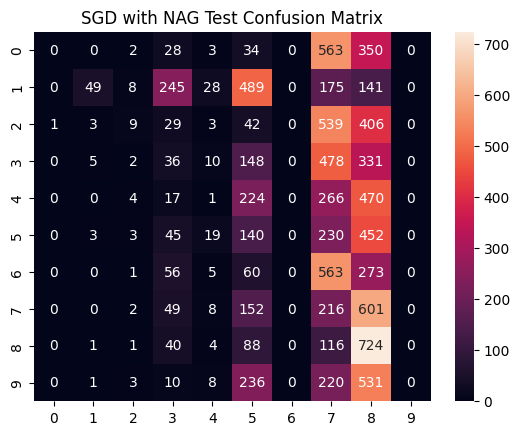


Training with RMSProp
Training stopped at epoch 2 with loss 2.3067994117736816


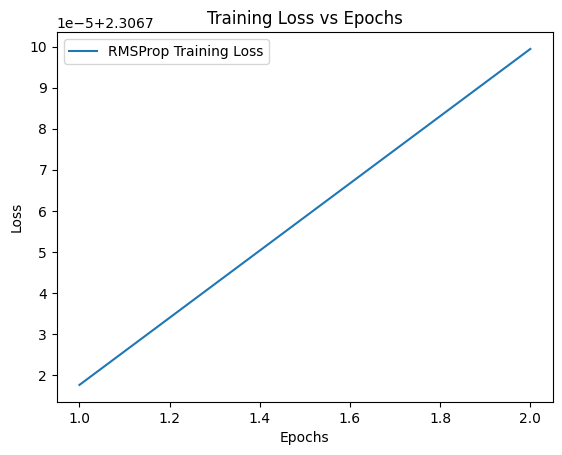

RMSProp Test Accuracy: 0.1010


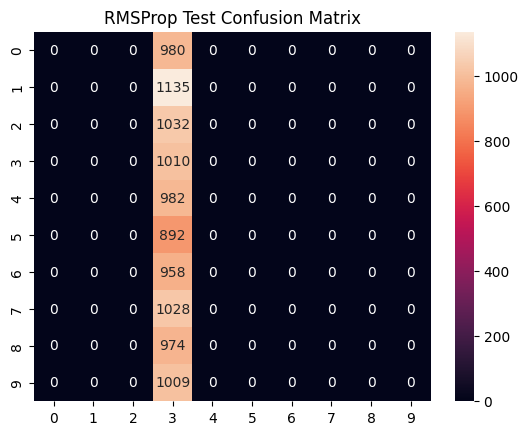


Training with Adam
Epoch 10, Loss: 1.9156203269958496
Epoch 20, Loss: 1.7962428331375122
Epoch 30, Loss: 1.7151468992233276
Epoch 40, Loss: 1.6960054636001587
Epoch 50, Loss: 1.6878920793533325
Epoch 60, Loss: 1.6822658777236938
Training stopped at epoch 67 with loss 1.6807868480682373


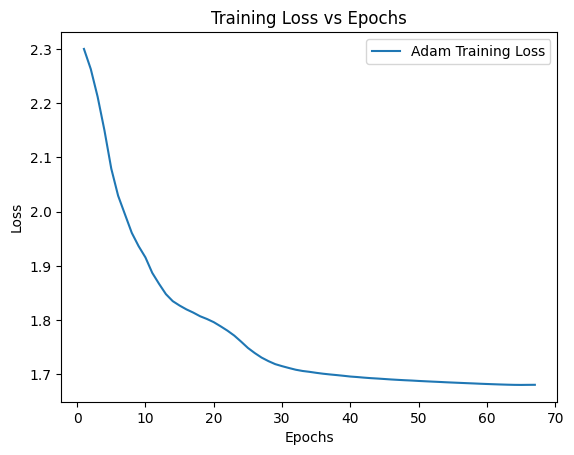

Adam Test Accuracy: 0.7725


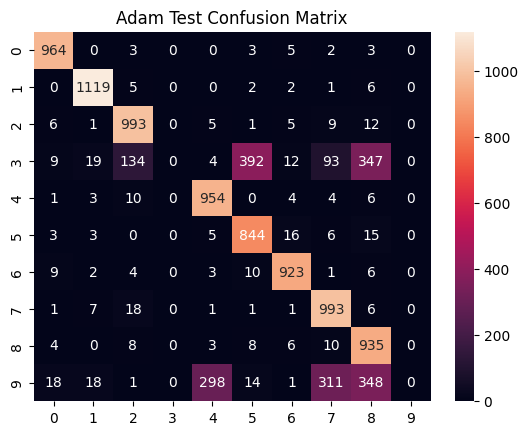

In [55]:
hidden_layers = [256, 128, 64, 32, 16]
optimizer_losses_dict.clear()



# Training with different optimizers
optimizers = {
    'SGD': optim.SGD,
    'SGD with momentum': lambda params: optim.SGD(params, lr=0.001, momentum=0.9),
    'SGD with NAG': lambda params: optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True),
    'RMSProp': lambda params: optim.RMSprop(params, lr=0.001, alpha=0.99),
    'Adam': lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
}

optimizer_losses_dict = {}

for optimizer_name, optimizer_func in optimizers.items():
    print(f"\nTraining with {optimizer_name}")
    model = NeuralNetwork(hidden_sizes=hidden_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_func(model.parameters())

    epochs, train_losses = train_model(model, optimizer, criterion, x_train_tensor, y_train_tensor)
    plot_training_loss(epochs, train_losses, optimizer_name)

    # Storing the losses for plotting
    optimizer_losses_dict[optimizer_name] = train_losses

    test_accuracy, conf_matrix = test_model(model, x_test_tensor, y_test_tensor)
    print(f"{optimizer_name} Test Accuracy: {test_accuracy:.4f}")

    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title(f'{optimizer_name} Test Confusion Matrix')
    plt.show()


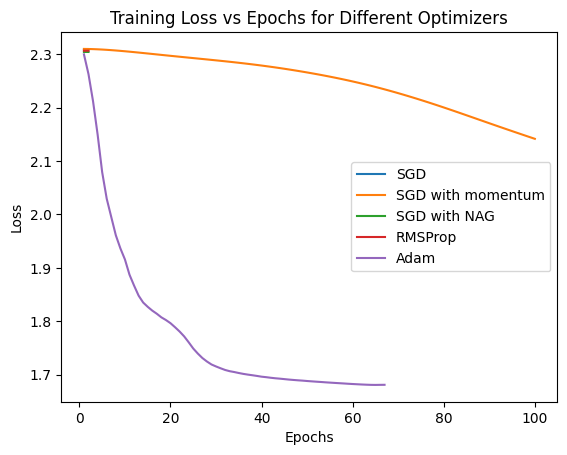

In [56]:
def plot_superimposed_losses(optimizer_losses_dict):
    for optimizer_name, losses in optimizer_losses_dict.items():
        plt.plot(range(1, len(losses)+1), losses, label=f'{optimizer_name}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs for Different Optimizers')
    plt.legend()
    plt.show()

plot_superimposed_losses(optimizer_losses_dict)
